<a href="https://colab.research.google.com/github/Kanabu1/customer--segmentation2/blob/main/customersegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_excel('/content/Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
#check for missing values
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
#handling missing values
data = data.dropna(subset=['CustomerID'])
# data.isnull().sum()

In [ ]:
#feature engineering
#slecting features that can be used for customer segmentation
cust_df = data[['CustomerID', 'Country', 'InvoiceDate', 'InvoiceNo', 'UnitPrice', 'Quantity']]

#invoice frequency
cust_df['InvoiceDate'] = pd.to_datetime(cust_df['InvoiceDate'])
cust_df['InvoiceMonth'] = cust_df['InvoiceDate'].dt.month
cust_df['InvoiceYear'] = cust_df['InvoiceDate'].dt.year
cust_df['InvoiceDay'] = cust_df['InvoiceDate'].dt.day
cust_df['InvoiceHour'] = cust_df['InvoiceDate'].dt.hour
cust_df['InvoiceMinute'] = cust_df['InvoiceDate'].dt.minute
cust_df['InvoiceSecond'] = cust_df['InvoiceDate'].dt.second


#time between purchases
cust_df['TimeBetweenPurchases'] = cust_df.groupby('CustomerID')['InvoiceDate'].diff().dt.days
cust_df['TimeBetweenPurchases'] = cust_df['TimeBetweenPurchases'].fillna(0)

#recency -days since last purchase
cust_df['Recency'] = (cust_df['InvoiceDate'].max() - cust_df.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days

#total amount spent by customer
cust_df['TotalAmount'] = cust_df.groupby('CustomerID')['UnitPrice'].transform('sum')
# cust_df.head()

cust_df = cust_df.drop('InvoiceDate', axis=1)
#customer activity
cust_df['InvoiceCount'] = cust_df.groupby('CustomerID')['InvoiceNo'].transform('count')

#one hot encoding country
cust_df = pd.get_dummies(cust_df, columns=['Country'])
# cust_df.head()
cust_df = cust_df.drop('InvoiceNo', axis=1)


cust_df.head()


,CustomerID,UnitPrice,Quantity,InvoiceMonth,InvoiceYear,InvoiceDay,InvoiceHour,InvoiceMinute,InvoiceSecond,TimeBetweenPurchases,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,17850.0,2.55,6,12,2010,1,8,26,0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,17850.0,3.39,6,12,2010,1,8,26,0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,17850.0,2.75,8,12,2010,1,8,26,0,0.0,...,False,False,False,False,False,False,False,False,True,False
3,17850.0,3.39,6,12,2010,1,8,26,0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,17850.0,3.39,6,12,2010,1,8,26,0,0.0,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
#Normalizing
#standard scaler
X = cust_df.values[:, 1:]
X = np.nan_to_num(X)
clus_dataset = StandardScaler().fit_transform(X)
clus_dataset

array([[-1.31352523e-02, -2.43726274e-02,  1.28520968e+00, ...,
        -1.29295915e-02,  3.52442756e-01, -2.44973573e-02],
       [-1.01667663e-03, -2.43726274e-02,  1.28520968e+00, ...,
        -1.29295915e-02,  3.52442756e-01, -2.44973573e-02],
       [-1.02498771e-02, -1.63305857e-02,  1.28520968e+00, ...,
        -1.29295915e-02,  3.52442756e-01, -2.44973573e-02],
       ...,
       [ 9.94774897e-03, -3.24146691e-02,  1.28520968e+00, ...,
        -1.29295915e-02, -2.83734020e+00, -2.44973573e-02],
       [ 9.94774897e-03, -3.24146691e-02,  1.28520968e+00, ...,
        -1.29295915e-02, -2.83734020e+00, -2.44973573e-02],
       [ 2.14892496e-02, -3.64356900e-02,  1.28520968e+00, ...,
        -1.29295915e-02, -2.83734020e+00, -2.44973573e-02]])

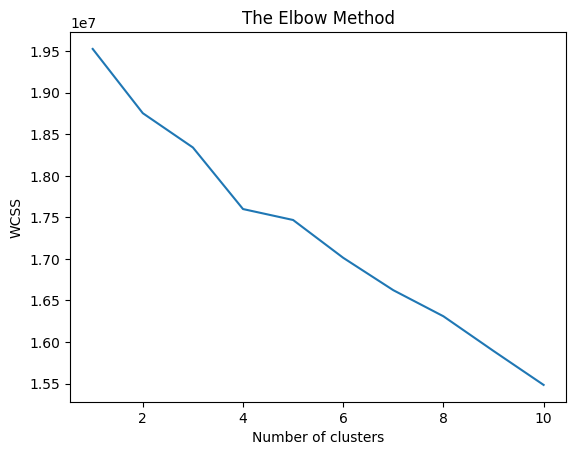

In [ ]:
#modeling
#k-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(clus_dataset)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
#evaluating clustering and selecting Optimal K
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(clus_dataset)
labels = kmeans.labels_
print(labels)
silhouette_avg = silhouette_score(clus_dataset, labels)
print("Silhouette score:", silhouette_avg)



[0 0 0 ... 1 1 1]
Silhouette score: 0.47182299077738704


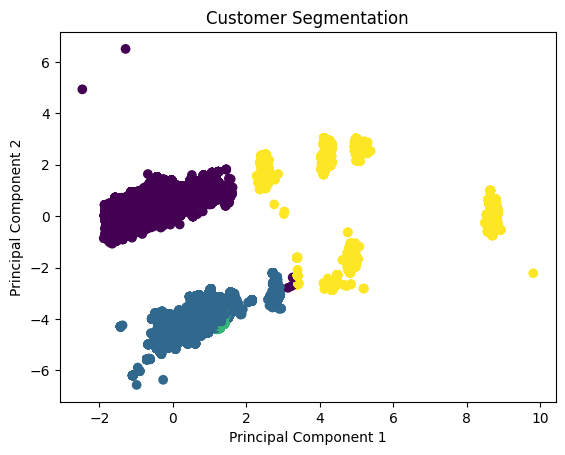

In [ ]:
#Visualize the cluster
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(clus_dataset)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segmentation')
plt.show()

Text(0, 0.5, 'Mean Value')

<Figure size 1000x600 with 0 Axes>

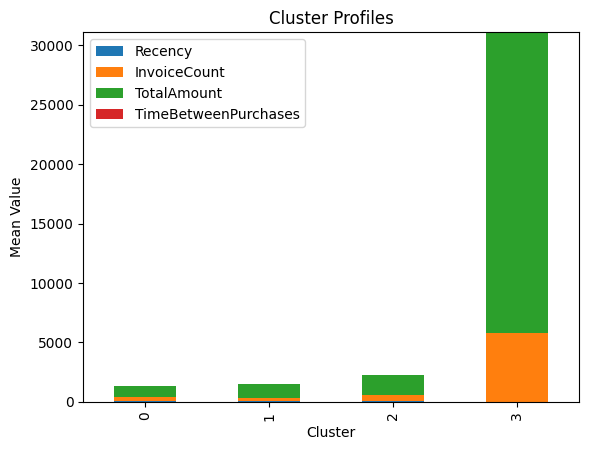

In [ ]:
#visualizing cluster profiles with bar charts
cust_df['Cluster'] = labels
cluster_profiles = cust_df.groupby('Cluster').mean()
cluster_profiles = cluster_profiles[['Recency', 'InvoiceCount', 'TotalAmount', 'TimeBetweenPurchases']]

plt.figure(figsize=(10, 6))
cluster_profiles.plot(kind='bar', stacked=True)
plt.title('Cluster Profiles')
plt.xlabel('Cluster')
plt.ylabel('Mean Value')

- The bar plot above compares recency, invoice count,total amount and time between purchases for each cluster

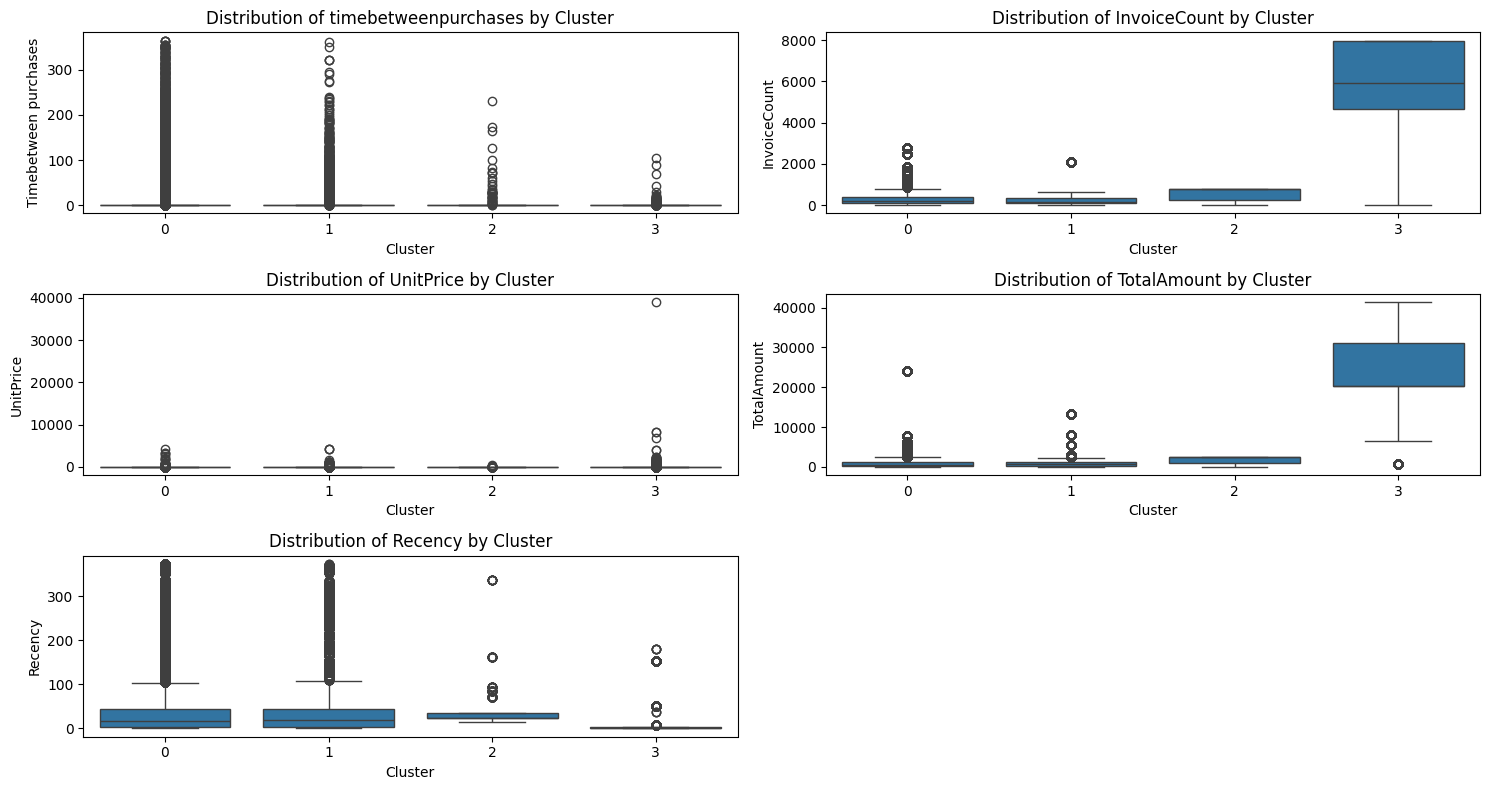

In [ ]:
#feature distribution for clusters with box plots
plt.figure(figsize=(15, 8))

plt.subplot(3, 2, 1)
sns.boxplot(x='Cluster', y='TimeBetweenPurchases', data=cust_df)
plt.title('Distribution of timebetweenpurchases by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Timebetween purchases')

plt.subplot(3, 2, 2)
sns.boxplot(x='Cluster', y='InvoiceCount', data=cust_df)
plt.title('Distribution of InvoiceCount by Cluster')
plt.xlabel('Cluster')
plt.ylabel('InvoiceCount')

plt.subplot(3, 2, 3)
sns.boxplot(x='Cluster', y='UnitPrice', data=cust_df)
plt.title('Distribution of UnitPrice by Cluster')
plt.xlabel('Cluster')

plt.subplot(3, 2, 4)
sns.boxplot(x='Cluster', y='TotalAmount', data=cust_df)
plt.title('Distribution of TotalAmount by Cluster')
plt.xlabel('Cluster')
plt.ylabel('TotalAmount')

plt.subplot(3,2,5)
sns.boxplot(x='Cluster', y='Recency', data=cust_df)
plt.title('Distribution of Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

after the analysis, this can be used to develop marketing strategies such as re-engaging low recency customers, rewarding high recency customers. or automated campaigns based on the cluster features.